# Weather Data
### by Line van Nifterik and Stoil Iliev

Packages:

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn scipy haversine networkx

Imports:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import haversine
import networkx as nx
import seaborn as sns
from scipy.linalg import eigh, eig
import sklearn
import scipy
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class WeatherGraphProcessor:
  def __init__(self, stations_file="weather_stations.csv", data_file="weather_data.csv"):
    self.stations_df = None
    self.weather_df = None
    self.start_date = None
    self.load_data(stations_file, data_file)
    self.GWS = None # Weather station graph
    self.eigenvalues = None
    self.eigenvects = None
    self.G_P = None

  def load_data(self, stations_file, data_file):
    try:
      # Load weather station data
      self.stations_df = pd.read_csv(stations_file)
      print(f"Loaded {len(self.stations_df)} weather stations")

      # Load weather measurement data
      self.weather_df = pd.read_csv(data_file, index_col=False)
      # Convert 'DATE' column to datetime objects
      self.weather_df['DATE'] = pd.to_datetime(self.weather_df['DATE'])
      print(f"Loaded {len(self.weather_df)} weather measurements")
      self.start_date = self.weather_df['DATE'].min()

      # Display basic info
      print("\nWeather stations columns:", list(self.stations_df.columns))
      print("Weather data columns:", list(self.weather_df.columns))
      print(f"Date range: {self.weather_df['DATE'].min()} to {self.weather_df['DATE'].max()}")

    except FileNotFoundError:
      print("File not found")

  def construct_weather_station_graph(self, alpha, beta, sparsification, k, threshold):
    # alpha: distance decay
    # beta: alt diff decay
    # sparsification: knn, threshold, none?
    # k: kNN number
    # threshold: for weight-based sparisification

    n_stations = len(self.stations_df)
    W = np.zeros((n_stations, n_stations))

    # get coordinates / altitudes
    lats = self.stations_df['LAT'].values
    lons = self.stations_df['LONG'].values
    heis = self.stations_df['HEI'].values

    # Compute pairwise distances
    for i in range(n_stations):
      for j in range(n_stations):
        if i != j:
          # Geographic
          d_ij = haversine.haversine((lats[i], lons[i]), (lats[j], lons[j]), unit=haversine.Unit.KILOMETERS)
          # Altitude difference
          h_ij = abs(heis[i] - heis[j]) / 1000  # Convert to km
          # Weight function
          W[i, j] = np.exp(-alpha * d_ij - beta * h_ij)

    # sparsification
    if sparsification == 'knn':
      # k-NN
      W_sparse = np.zeros_like(W)
      for i in range(n_stations):
        neighbors = np.argsort(W[i, :])[-k-1:-1] # Exclude self (highest weight)
        W_sparse[i, neighbors] = W[i, neighbors]
      # Make symmetric (mutual k-NN)
      W =(W_sparse + W_sparse.T) / 2

    elif sparsification == 'threshold':
      W[W < threshold] = 0

    # Store the graph
    self.GWS = W

    # Compute graph Laplacian and its eigendecomposition
    D = np.diag(np.sum(W, axis=1))
    L = D - W  # Combinatorial Laplacian

    # Compute eigenvalues and eigenvectors
    self.eigenvals, self.eigenvecs = eigh(L)

    print(f"Constructed weather station graph with {n_stations} nodes")
    print(f"Sparsification: {sparsification}, Non-zero edges: {np.sum(W > 0)}")
    print(f"Graph density: {np.sum(W > 0) / (n_stations * (n_stations - 1)):.3f}")

    return W

  def draw_weather_station_graph(self):
    if self.GWS is None:
      print("Weather station graph not constructed yet.")
      return

    G = nx.from_numpy_array(self.GWS)

    # Get positions for nodes (using station coordinates)
    pos = {i: (self.stations_df['LONG'][i], self.stations_df['LAT'][i]) for i in range(len(self.stations_df))}

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_size=10, width=0.1)
    plt.title("Weather Station Graph")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

  def construct_path_graph(self, time_steps): # 34 for nb of months between start and end
    self.G_P = nx.path_graph(time_steps)

Loaded 76 weather stations
Loaded 40921 weather measurements

Weather stations columns: ['ID', 'SITE', 'LAT', 'LONG', 'HEI', 'OP']
Weather data columns: ['ID', 'DATE', 'QUALITY', 'MIN_5CM', 'MIN_2M', 'MEAN_2M', 'MAX_2M', 'REL_HUMIDITY', 'MEAN_WIND_STRENGTH', 'MAX_WIND_SPEED', 'SUNSHINE', 'MEAN_CLOUDINESS', 'PRECIPITATION', 'MEAN_PRESSURE']
Date range: 2018-09-08 00:00:00 to 2021-06-13 00:00:00
Constructed weather station graph with 76 nodes
Sparsification: knn, Non-zero edges: 400
Graph density: 0.070


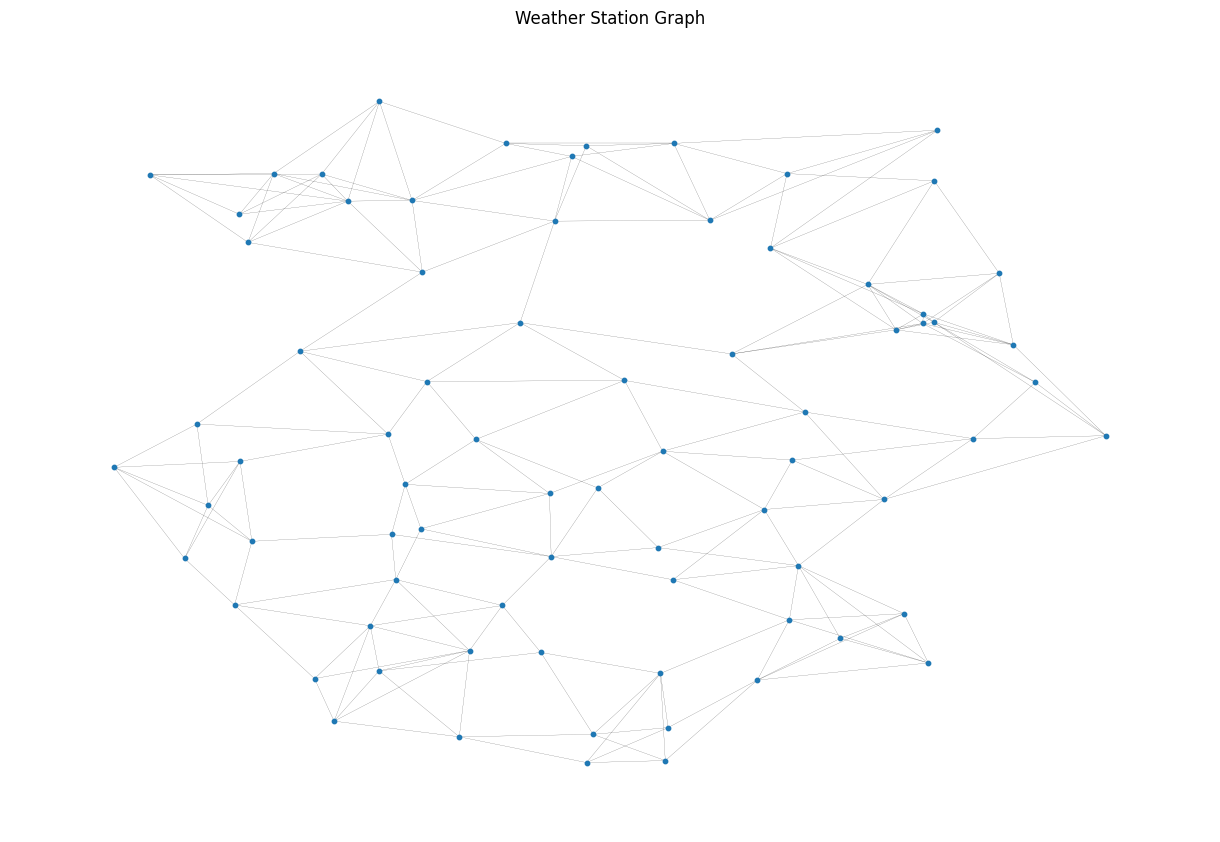

In [ ]:
# Instantiate the WeatherGraphProcessor
weather_processor = WeatherGraphProcessor()

# Construct the weather station graph
# k-NN
weather_processor.construct_weather_station_graph(alpha=0.1, beta=0.001, sparsification="knn", k = 4, threshold=0.00001)
# Threshold
# weather_processor.construct_weather_station_graph(alpha=0.1, beta=0.001, sparsification='threshold', threshold=0.00001)

# Draw the graph
weather_processor.draw_weather_station_graph()

In [ ]:
weather_processor.construct_path_graph(34)

In [ ]:
weather_processor.weather_df.head(5)

,ID,DATE,QUALITY,MIN_5CM,MIN_2M,MEAN_2M,MAX_2M,REL_HUMIDITY,MEAN_WIND_STRENGTH,MAX_WIND_SPEED,SUNSHINE,MEAN_CLOUDINESS,PRECIPITATION,MEAN_PRESSURE
0,102,2019-12-12,3.0,NaN,3.3,4.9,5.8,87.54,10.1,17.9,3.433,NaN,NaN,992.46
1,102,2019-12-13,3.0,NaN,2.0,2.7,3.7,86.08,10.7,21.0,0.017,NaN,NaN,976.26
2,102,2019-12-14,3.0,NaN,3.6,5.4,6.6,88.67,14.1,26.6,1.667,NaN,NaN,979.45
3,102,2019-12-15,3.0,NaN,4.4,6.3,8.1,81.38,16.3,30.4,4.850,NaN,NaN,989.41
4,102,2019-12-16,3.0,NaN,5.3,6.5,7.9,89.58,9.2,16.3,0.167,NaN,NaN,999.68


In [ ]:
def get_A(G):
    A = nx.adjacency_matrix(G)
    A = A.astype('float')
    return(A)

def get_norm_L(G):
    L = nx.normalized_laplacian_matrix(G, weight=None)
    L = L.astype('float')
    return(L)

In [ ]:
def construct_spacetime_graph(self):
  if self.GWS is None:
    raise ValueError("Must construct weather station graph first")

  n_stations = self.GWS.shape[0]

  # # Create path graph for time (adjacency matrix)
  # A_GP = np.zeros((time_steps, time_steps))
  # for i in range(time_steps - 1):
  #   A_GP[i, i+1] = 1
  #   A_GP[i+1, i] = 1

  A_GP = nx.to_numpy_array(self.G_P, dtype=float)

  # Kronecker product: A_GWS (x) I_t + I_n (x) A_GP
  time_steps = self.G_P.number_of_nodes()
  I_t = np.eye(time_steps)
  I_n = np.eye(n_stations)

  G_time_WS = np.kron(self.GWS, I_t) + np.kron(I_n, A_GP)

  print(f"Constructed spatio-temporal graph with {n_stations * time_steps} nodes")
  return G_time_WS

In [ ]:
G_time_WS = construct_spacetime_graph(weather_processor)

Constructed spatio-temporal graph with 2584 nodes


In [ ]:
def date_to_period_id(self, date):
    start_date = self.start_date
    print(date, start_date)
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    if isinstance(date, str):
        date = pd.to_datetime(date)
    time_period_id = (date.year-start_date.year) * 12 + (date.month-start_date.month)
    return time_period_id

In [ ]:
def period_id_to_time_period(self, period_id):
    start_date = self.start_date
    t1 = start_date + pd.DateOffset(months=period_id)
    t2 = t1 + pd.DateOffset(months=1)
    print(t1, t2)

In [ ]:
def node_to_signal(self, id_station, time_id, measurement): # measurement we are interested in, e.g. MEAN_2M
    start_date = self.start_date
    df_weat = self.weather_df
    t1 = start_date + pd.DateOffset(months=time_id)
    t2 = t1 + pd.DateOffset(months=1)
    filtered_df = df_weat[(df_weat['DATE'] >= t1)
                          & (df_weat['DATE'] < t2)
                          & (df_weat['ID']==id_station)]
    signal_sc = filtered_df[measurement].mean()
    return signal_sc

# Note: If we want all measurements at once (like multiple columns), we can extend measurement to be a list of column names:
# signal_vec = filtered_df[measurement].to_numpy()
# e.g. measurement = ["MEAN_2M", "PRECIPITATION"] -> then signal_vec will be a 2D array (days × variables).

In [ ]:
def get_signal_for_one_id(self, station_id, measurement):
    L=[]
    time_steps = self.G_P.number_of_nodes()
    for t in range(time_steps):
        L.append(node_to_signal(self, station_id, t, measurement))
    return(np.array(L))

In [ ]:
# def get_signal_matrix(self, measurement):
#     n = self.GWS.shape[0]
#     m = self.G_P.number_of_nodes()
#     signal = np.zeros((n,m))
#     for i in range(n):
#         # Each row i correspond to the masuremnt measured throughout time periods for station i
#         signal[i,:] = get_signal_for_one_id(self, i, measurement)
#     return(signal) # 76x34 matrix

In [ ]:
def get_signal_matrix(self, measurement):
    station_ids = self.stations_df["ID"].unique()
    n = len(station_ids)
    m = self.G_P.number_of_nodes()
    signal = np.zeros((n, m))
    for i, station_id in enumerate(station_ids):
        signal[i, :] = get_signal_for_one_id(self, station_id, measurement)
    return signal

In [ ]:
def get_signal_vec(self, measurement):
    signal_matrix = get_signal_matrix(self,  measurement)
    signal_vec = signal_matrix.flatten()
    return(signal_vec)

In [ ]:
def get_eigenvector_matrix(self, G):
    A_G = get_A(G)
    # print("Eigenvalues:", eigvals)
    # print("Eigenvectors shape:", eigvecs.shape)
    eigvals, eigvecs = np.linalg.eigh(A_G)
    return(eigvals, eigvecs)

In [ ]:
# def get_eigenvector_matrix_G_time_WS(self):
#     G = construct_spacetime_graph(self)
#     A_G = get_A(G)
#     # print("Eigenvalues:", eigvals)
#     # print("Eigenvectors shape:", eigvecs.shape)
#     eigvals, eigvecs = np.linalg.eig(A_G)
#     return(eigvecs)

In [ ]:
def graph_fourier_transform(self, signal, G): # signal is 76x34 (33 measurements per station)=2508
    M, W = get_eigenvector_matrix(self, G)
    return(W.T @ signal)

In [ ]:
def inverse_graph_fourier_transform(self, signal, G_WS): # signal is 76x34 (33 measurements per station)=2508 (vector of len 2508 when flatttened)
    M, W = get_eigenvector_matrix(self, G_WS)
    return(W @ signal)

In [ ]:
def spatial_signal(self, period_id, measurement):
    signal_matrix = get_signal_matrix(self, measurement)
    print(signal_matrix.shape)
    signal = signal_matrix[:,period_id]
    # Handle NaN values by filling them with the mean of the non-NaN values
    signal = np.nan_to_num(signal, nan=np.nanmean(signal))
    return signal

In [ ]:
def draw_frequency_spatial_signal(self, period_id, measurement):
    signal = spatial_signal(self, period_id, measurement)
    print(signal.shape)
    print(f"signal:{signal}")
    eigvals, eigvecs = np.linalg.eigh(self.GWS)
    print(eigvecs)
    print(eigvecs.shape)
    s_hat = eigvecs.T @ signal
    plt.figure(figsize=(8,4))
    plt.stem(np.arange(len(s_hat)), np.abs(s_hat))
    plt.xlabel("Eigenvalue index")
    plt.ylabel("|s_hat| (spectral magnitude)")
    plt.title("Graph Fourier Transform")
    plt.show()

In [ ]:
# start_date = pd.to_datetime("2018-09-08")

In [ ]:
date_to_period_id(weather_processor, "2019-12-17")

2019-12-17 2018-09-08 00:00:00


15

In [ ]:
period_id_to_time_period(weather_processor, 15)

2019-12-08 00:00:00 2020-01-08 00:00:00


(76, 34)
(76,)
signal:[ 5.75185185  3.74814815  4.11851852  2.13333333  2.33333333  3.88888889
  4.26296296  4.34074074  4.86296296 -0.03703704  4.22962963  5.34444444
  3.60090679  4.13703704  6.24814815  7.24117647  2.17037037  3.52962963
  1.1        -0.62592593  4.48888889  3.13703704  3.15925926  3.75185185
  3.07407407  3.82962963  4.16296296  5.24074074 -0.62962963  4.62962963
  4.92592593  6.48888889  1.93333333  3.73703704  1.43703704  2.21481481
  4.9         5.92222222  3.54444444  4.78888889  4.10740741  5.23333333
  3.65185185  5.04444444  5.64074074  4.13333333  3.88148148  2.08148148
  3.60090679  5.43703704  3.8962963   2.90740741  1.73333333  4.59259259
  3.64444444  1.91851852  4.44074074  4.85925926  4.37777778  4.45925926
  4.07037037  2.74444444  2.08518519  3.36666667  4.87407407  1.37407407
  1.67407407  5.02222222  3.44444444 -7.40740741  5.11851852  2.10740741
  3.31851852  4.78518519  4.33703704  5.9962963 ]
[[ 3.86708617e-21  1.61518141e-16  7.25771021e-01 ..

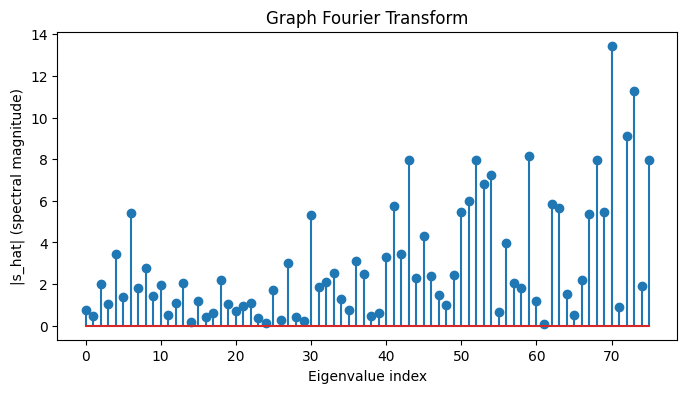

In [ ]:
draw_frequency_spatial_signal(weather_processor, 15, "MEAN_2M")

In [ ]:
def draw_frequency_spatio_temp_signal(self, period_id,  start_date, measurement):
    G_prod = construct_spacetime_graph(self)
    signal = get_signal_vec(self, period_id, start_date, measurement)
    s_hat = graph_fourier_transform(self, signal, G_prod)
    plt.figure(figsize=(8,4))
    plt.stem(np.arange(len(s_hat)), np.abs(s_hat))
    plt.xlabel("Eigenvalue index")
    plt.ylabel("|s_hat| (spectral magnitude)")
    plt.title("Graph Fourier Transform")
    plt.show()

Let's visualize the 'MEAN_2M' signal for different time periods on the weather station graph (GWS). We'll compare a winter month (period_id 15), a spring month (period_id 19), a summer month (period_id 22), and an autumn month (period_id 25).

Spectral properties on Weather Station Graph (GWS):

Winter (Period ID 15):
(76, 34)
(76,)
signal:[ 5.75185185  3.74814815  4.11851852  2.13333333  2.33333333  3.88888889
  4.26296296  4.34074074  4.86296296 -0.03703704  4.22962963  5.34444444
  3.60090679  4.13703704  6.24814815  7.24117647  2.17037037  3.52962963
  1.1        -0.62592593  4.48888889  3.13703704  3.15925926  3.75185185
  3.07407407  3.82962963  4.16296296  5.24074074 -0.62962963  4.62962963
  4.92592593  6.48888889  1.93333333  3.73703704  1.43703704  2.21481481
  4.9         5.92222222  3.54444444  4.78888889  4.10740741  5.23333333
  3.65185185  5.04444444  5.64074074  4.13333333  3.88148148  2.08148148
  3.60090679  5.43703704  3.8962963   2.90740741  1.73333333  4.59259259
  3.64444444  1.91851852  4.44074074  4.85925926  4.37777778  4.45925926
  4.07037037  2.74444444  2.08518519  3.36666667  4.87407407  1.37407407
  1.67407407  5.02222222  3.44444444 -7.40740741  5.11851852  2.10740741
  3.31851852  4.78518519  

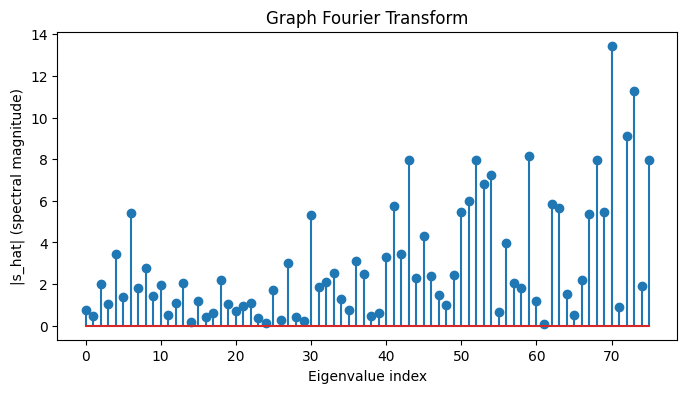


Spring (Period ID 19):
(76, 34)
(76,)
signal:[ 8.98       10.17333333  8.51666667 11.04666667 10.86333333 10.96
 11.33333333 11.44666667 10.44666667  4.95666667 10.93333333  9.68
  8.49333333 11.28       12.50666667 10.40589744 11.15       10.34666667
  6.92333333  5.40333333 13.21333333 10.61       11.02307692 10.46333333
 11.37666667 10.66        9.34333333 11.45333333  5.37666667  9.76
 10.55666667  9.01        9.65666667 10.36333333  8.33       10.95
  9.13       12.72666667 13.67666667 13.95       10.90333333  9.26333333
 10.99333333 11.24333333  8.71666667 11.44        9.89333333 10.48666667
 10.40589744  9.26       10.89       11.78        9.98666667 13.15666667
 11.22333333 11.84666667 13.26666667  9.62       12.79333333  9.05666667
  9.96       11.12333333 11.68666667 12.44666667 12.73333333  8.42333333
 10.66666667  9.27333333 12.65333333 -2.87666667  9.44333333 11.84
 11.42       13.72666667 12.62666667 12.        ]
[[ 3.86708617e-21  1.61518141e-16  7.25771021e-01 ... -6.8

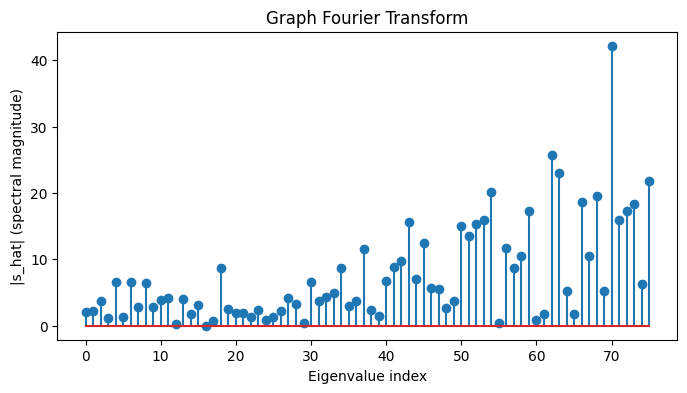


Summer (Period ID 22):
(76, 34)
(76,)
signal:[17.04516129 18.43225806 16.85483871 18.5        18.79677419 18.52580645
 19.15806452 19.60967742 17.70322581 12.20322581 19.24516129 17.43870968
 16.40322581 19.4        19.41935484 17.92920663 18.40322581 18.46451613
 13.40645161 13.16451613 21.16774194 17.52903226 18.31935484 18.99677419
 19.33548387 18.60967742 17.26129032 18.12580645 12.87096774 17.12903226
 18.06129032 17.04516129 17.58709677 17.04516129 14.73548387 17.88064516
 16.67419355 19.20645161 20.69354839 21.10645161 19.52580645 16.99032258
 18.92903226 17.90967742 16.56451613 19.00322581 17.3516129  17.98387097
 17.92920663 17.32258065 17.57096774 19.78709677 17.1        20.71935484
 18.77419355 19.75806452 21.29032258 18.00322581 19.81935484 16.29677419
 17.45483871 18.27096774 19.08709677 20.04516129 20.00967742 15.44193548
 18.76129032 17.43548387 20.47741935  3.80322581 16.85483871 18.66774194
 18.13225806 21.17096774 20.5483871  18.34516129]
[[ 3.86708617e-21  1.6151814

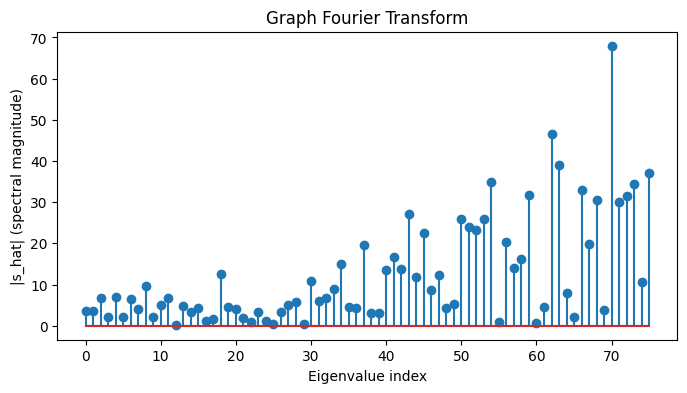


Autumn (Period ID 25):
(76, 34)
(76,)
signal:[11.49032258 10.25483871 10.77741935  8.56129032  8.89677419 10.37096774
 10.65483871 10.90322581 10.43548387  4.07419355 10.56774194 11.21612903
  9.34598954 10.05483871 11.20322581 12.51290323  8.37741935  9.51290323
  3.98064516  4.44516129 10.45483871  7.48064516  9.49354839  9.54193548
  9.51290323  9.82903226 10.72903226 10.60967742  4.05806452 10.58387097
 10.8        12.20322581  7.91290323  7.53225806  6.0516129   7.76129032
 10.77096774 10.91935484  9.3516129  10.82903226 10.40322581 11.24516129
 10.30967742 10.42580645 11.00645161 10.98387097 10.12258065  8.19354839
  9.34598954 11.25806452  8.60967742  9.11612903  6.73225806 10.37741935
 10.09032258  8.47096774 10.75483871 11.31290323  9.81612903 10.08064516
 10.39354839  7.65806452  8.59677419  9.50322581 10.18064516  6.06129032
  8.16129032 11.33548387  9.69354839 -2.85483871 10.52580645  8.12580645
  8.60645161 10.85806452 10.37419355 10.35806452]
[[ 3.86708617e-21  1.6151814

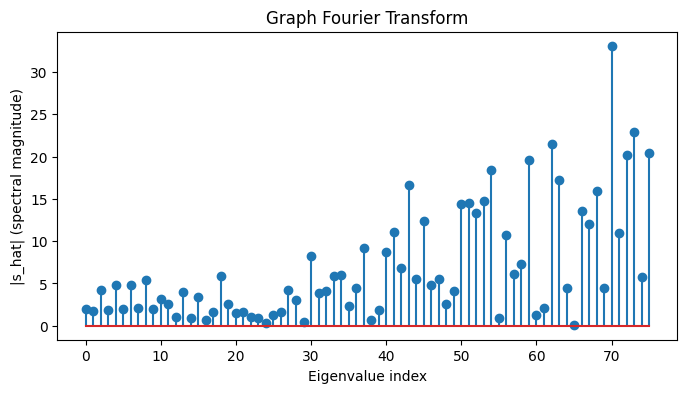

In [45]:
# Define period IDs for different seasons
winter_period_id = 15 # December
spring_period_id = 19 # April
summer_period_id = 22 # July
autumn_period_id = 25 # October

# Draw for each season on GWS
print("Spectral properties on Weather Station Graph (GWS):")

print("\nWinter (Period ID 15):")
draw_frequency_spatial_signal(weather_processor, winter_period_id, "MEAN_2M")

print("\nSpring (Period ID 19):")
draw_frequency_spatial_signal(weather_processor, spring_period_id, "MEAN_2M")

print("\nSummer (Period ID 22):")
draw_frequency_spatial_signal(weather_processor, summer_period_id, "MEAN_2M")

print("\nAutumn (Period ID 25):")
draw_frequency_spatial_signal(weather_processor, autumn_period_id, "MEAN_2M")

Visualization of the 'MEAN_2M' signal on the spatio-temporal graph (G_time_WS).


Spatio-Temporal Graph (G_time_WS):
Constructed spatio-temporal graph with 2584 nodes


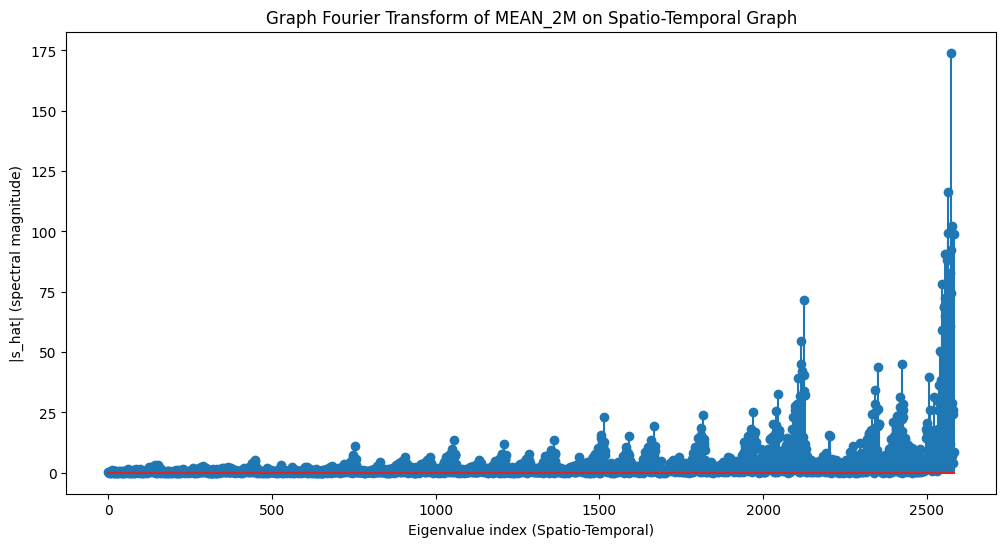

In [49]:
print("\nSpatio-Temporal Graph (G_time_WS):")

# Get the flattened signal for 'MEAN_2M' over all time steps
signal_vec_mean_2m = weather_processor.get_signal_vec("MEAN_2M")

# Construct the spatio-temporal graph
G_time_WS = construct_spacetime_graph(weather_processor)

# Compute Graph Fourier Transform on G_time_WS
eigvals_G_time_WS, eigvecs_G_time_WS = np.linalg.eigh(G_time_WS)

# Handle NaNs in the flattened signal
signal_vec_mean_2m = np.nan_to_num(signal_vec_mean_2m, nan=np.nanmean(signal_vec_mean_2m))

# Compute GFT
s_hat_G_time_WS = eigvecs_G_time_WS.T @ signal_vec_mean_2m

# Draw frequency domain representation
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(s_hat_G_time_WS)), np.abs(s_hat_G_time_WS))
plt.xlabel("Eigenvalue index (Spatio-Temporal)")
plt.ylabel("|s_hat| (spectral magnitude)")
plt.title("Graph Fourier Transform of MEAN_2M on Spatio-Temporal Graph")
plt.show()